# Bayes models: CIb
#### Transformation model based variational inference (TM-VI)
#### Image data: CIb model , compare MF-Gaussian-VI with MF-TM-VI (last layer FCNN)

In [2]:
# packages
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import seaborn as sns
from numpy.random import seed
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
from tensorflow.keras import layers
from functions.scoreCI import score_ci
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from tensorflow.keras import regularizers
import glob
#%load_ext autoreload
#%autoreload 2
#functions
from functions.vimlts import VimltsLinear,DenseViGauss 
from functions.sample_bernoulli_nll import sample_bernoulli_nll
from functions.logScore import logScore
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
## add resize images and add path to patient
dat = pd.read_csv('../thesis/patientData.csv')
train_dir = "../thesis/trainRes/"
dat['path'] = train_dir + dat.image_name + ".jpg"


In [4]:
np.random.seed(3004)
idx = np.arange(len(dat))
np.random.shuffle(idx)


train_idx = idx[:int(len(dat)*0.8)] # 80% training
test_idx = idx[int(len(dat)*0.8):] # 20% test
valid_idx = train_idx[:int(len(train_idx)*0.2)] # 20% of training as validation
train_idx = train_idx[int(len(train_idx)*0.2):]
print(train_idx.shape, valid_idx.shape, test_idx.shape)

(21200,) (5300,) (6626,)


In [5]:
X_train = dat.iloc[train_idx]
X_valid= dat.iloc[valid_idx]
X_test= dat.iloc[test_idx]
print(X_train.shape, X_valid.shape, X_test.shape)

(21200, 9) (5300, 9) (6626, 9)


In [6]:
y_train = dat.iloc[train_idx]
y_train = y_train.loc[:, y_train.columns.intersection(['target'])]
y_valid= dat.iloc[valid_idx]
y_valid = y_valid.loc[:, y_train.columns.intersection(['target'])]
y_test= dat.iloc[test_idx]
y_test = y_test.loc[:, y_train.columns.intersection(['target'])]
print(y_train.shape, y_valid.shape, y_test.shape)

(21200, 1) (5300, 1) (6626, 1)


In [7]:
# save image path
train_files = X_train.path
val_files = X_valid.path
test_files = X_test.path

# img_to_array image transform to array 
train_imgs = [img_to_array(load_img(img)) for img in train_files]
validation_imgs = [img_to_array(load_img(img)) for img in val_files]
test_imgs = [img_to_array(load_img(img)) for img in test_files]

train_imgs = np.array(train_imgs)
train_labels = y_train

validation_imgs = np.array(validation_imgs)
val_labels = y_valid
#
test_imgs = np.array(test_imgs)
test_labels = y_test


print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape,
     '\Test dataset shape:', test_imgs.shape)

Train dataset shape: (21200, 128, 128, 3) 	Validation dataset shape: (5300, 128, 128, 3) \Test dataset shape: (6626, 128, 128, 3)


In [8]:
#scale pixel between 0 und 1

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled  = test_imgs.astype('float32')
train_labels = train_labels.astype("float32")
val_labels = val_labels.astype("float32")
val_labels = val_labels.astype("float32")
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

#plt.imshow(train_imgs_scaled[0])


### OOD and augmentation data

In [9]:
## random images 
filelist = glob.glob('./oodImages/*.npy')
x = [np.array(np.load(fname)) for fname in filelist]
randomX = np.asarray(x)
oodRandom = randomX.reshape(17,128,128,3)
oodRandom.shape

(17, 128, 128, 3)

In [10]:
## augmentation images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(factor=0.9, fill_mode="wrap"),
  layers.experimental.preprocessing.RandomTranslation(height_factor=1, width_factor=1, fill_mode="reflect"),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
])
# Add the image to a batch
image= test_imgs_scaled[300:403] 
augmented_image = data_augmentation(image)
bright = tf.image.adjust_brightness(augmented_image, 0.2) ##add additionaly brightness 
bright.shape
#plt.imshow(bright[10])
#plt.axis("off")

TensorShape([103, 128, 128, 3])

### Functions

In [11]:
def softplus_inv(y):
    return np.log(np.exp(y) - 1)



#combine two components
def modelOn(X):
    added = X.layers[14].output   ## before sigmoid to obtain eta(B)
    out = tf.math.sigmoid(added)
    model1 = keras.Model(inputs = X.input, outputs = out, name='model_XXX')
    return model1 
    
prior_dist=tfd.Normal(loc=0.,scale=1.)

## Gauß-VI last-layer eta Bild

In [12]:
## Complex shift image
from tensorflow.keras import regularizers

    
in_ = keras.Input(shape = (128,128,3), name = "inImg")
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(in_)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01), ##numerical stability
                activity_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
out= DenseViGauss(units=1,
                      size= train_imgs_scaled.shape[0],
                      activation=tf.keras.activations.linear,
                      num_samples=1000,     
                      prior_dist=prior_dist)(x)

nn_imG = keras.Model (inputs = in_, outputs = out)
nn_imG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inImg (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0     

In [13]:
nn_image = modelOn(nn_imG)
nn_image.compile(optimizer=Adam(1e-4), loss=sample_bernoulli_nll, run_eagerly=False)  

#### Train model

In [ ]:
nn_image.compile(optimizer=Adam(1e-4), loss=sample_bernoulli_nll, run_eagerly=False)  
results = nn_image.fit(x = train_imgs_scaled, 
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 100,
                        verbose= True)    

In [15]:
# save results
#dat = pd.DataFrame({'train_loss': results.history['loss'], 
 #                      'test_loss': results.history['val_loss']})
#dat.to_csv('../thesis/performance/gaussVI/history.csv', index=False)

### save model weights whole model
#nn_image.save_weights("../thesis/models/CNNGaus", save_format ="tf")
### save model weights eta
#nn_imG.save_weights("../thesis/models/CNNGaussEta", save_format ="tf")


#### Load model weights

In [14]:
### recreate Model eta
nn_imG.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_imG.load_weights("../thesis/models/CNNGaussEta")

### recreate whole Model
nn_image.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_image.load_weights("../thesis/models/CNNGaus")

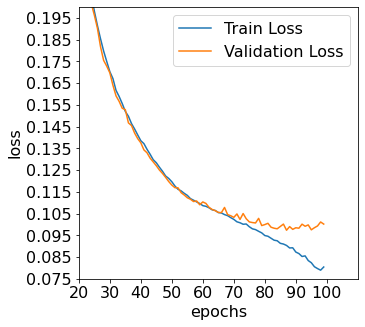

In [35]:

plt.figure(figsize=(5,5))
plt.rcParams.update(({'font.size': 16}))
loss0 = pd.read_csv('../thesis/performance/gaussVI/history.csv')
plt.plot(loss0['train_loss'],label="Train Loss")
plt.plot(loss0['test_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0.075,0.2)
plt.yticks(np.arange(0.075, 0.2, 0.01))
plt.xticks(np.arange(20, 110, 10))
plt.xlim(20,110)
plt.legend()
plt.savefig("../thesis/plots/uncertainty/LOSS_CIbGaussVIx.pdf",bbox_inches='tight')
plt.show()

## Performance

In [21]:
y_pred = nn_image.predict(test_imgs_scaled,batch_size =1)

samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

In [22]:
logScore(test_labels,predictions)

-0.07688304286167824

In [23]:
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)

AUC=0.83, 95% CI: 0.79-0.86


### Prediction on OOD and testdata (ID) eta(B) 

In [33]:

# theta with random images
Gy_predTabOOD = nn_imG.predict(oodRandom,batch_size =1)
GsamplesImgOOD = Gy_predTabOOD.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOOD = GsamplesImgOOD.mean(axis=1)  ###mean samples 
GpredictionsImgOOD=GmeanpredImgOOD.reshape(17,1)
# IQR quantiles
Gy_predictions_25ImgOOD=np.quantile(GsamplesImgOOD,0.25,axis=1)  
Gy_predictions_75IMGOOD=np.quantile(GsamplesImgOOD,0.75,axis=1)

# data
GImgCenterOOD = [sublist[-1] for sublist in GpredictionsImgOOD]
GImgLowOOD = [sublist[-1] for sublist in Gy_predictions_25ImgOOD.reshape(17,1)]
GImgHighOOD = [sublist[-1] for sublist in Gy_predictions_75IMGOOD.reshape(17,1)]
# IQR range
GImgwidthOOD= [x1 - x2 for (x1, x2) in zip(GImgHighOOD, GImgLowOOD)]

#theta augmented images
Gy_predTabOODA = nn_imG.predict(bright,batch_size =1)
GsamplesImgOODA = Gy_predTabOODA.reshape(-1, 1000) ###every datapoint one sample
GmeanpredImgOODA = GsamplesImgOODA.mean(axis=1)  ###mean samples 
GpredictionsImgOODA=GmeanpredImgOODA.reshape(103,1)
# IQR quantiles
Gy_predictions_25ImgOODA=np.quantile(GsamplesImgOODA,0.25,axis=1)
Gy_predictions_75IMGOODA=np.quantile(GsamplesImgOODA,0.75,axis=1)

#data
GImgCenterOODA = [sublist[-1] for sublist in GpredictionsImgOODA]
GImgLowOODA = [sublist[-1] for sublist in Gy_predictions_25ImgOODA.reshape(103,1)]
GImgHighOODA = [sublist[-1] for sublist in Gy_predictions_75IMGOODA.reshape(103,1)]
#IQR range
GImgwidthOODA= [x1 - x2 for (x1, x2) in zip(GImgHighOODA, GImgLowOODA)]

In [34]:
# in-distribution

Gy_pred = nn_imG.predict(test_imgs_scaled[0:120],batch_size =1)
Gsamples = Gy_pred.reshape(-1, 1000) ###every datapoint one sample
Gmeanpred = Gsamples.mean(axis=1)  ###mean samples 
Gpredictions=Gmeanpred.reshape(120,1)

Gy_predictions_25=np.quantile(Gsamples,0.25,axis=1)
Gy_predictions_75=np.quantile(Gsamples,0.75,axis=1)

GImgCenter = [sublist[-1] for sublist in Gmeanpred.reshape(120,1)]
GImgLow = [sublist[-1] for sublist in Gy_predictions_25.reshape(120,1)]
GImgHigh = [sublist[-1] for sublist in Gy_predictions_75.reshape(120,1)]
GImgwidth= [x1 - x2 for (x1, x2) in zip(GImgHigh, GImgLow)]

# Testdata
Gimagedata = pd.DataFrame(
    {'Gwidth': GImgwidth,
     'Gcenter': GImgCenter
    })

#Out of distribution random images

GimagadataOOD = pd.DataFrame(
    {'Gwidth': GImgwidthOOD,
     'Gcenter': GImgCenterOOD
    })

#Out of distribution augmented

GimagadataOODA = pd.DataFrame(
    {'Gwidth': GImgwidthOODA,
     'Gcenter': GImgCenterOODA
    })

## CNN Last layer TMVI

In [17]:

### Kein Bias Bei Linear Shift
M=50
theta_start = -3  ##Range Gauss-VI
theta_stop = 3
num_samples=1000


vimlts_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] +
                              [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])                 

In [18]:
in_ = keras.Input(shape = (128,128,3), name = "inImg")
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(in_)
x = layers.MaxPooling2D(pool_size=(2, 2))(x) 
x = layers.Convolution2D(32, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(64, kernel_size=(3, 3,), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Convolution2D(128, kernel_size=(3, 3), padding = 'same', 
                             activation = 'tanh')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
x = layers.Dense(128, activation = 'tanh',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01))(x)
eta = VimltsLinear(units=1,
                      activation=tf.keras.activations.linear,    ###Linear
                      num_samples=num_samples,
                      size = train_imgs_scaled.shape[0],
                      **vimlts_initializers,
                      prior_dist=prior_dist)(x)
nn_im = keras.Model (inputs = in_, outputs = eta)
nn_im.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inImg (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      896       
_____________________________________________________

In [19]:
nn_imageTMVI = modelOn(nn_im)
nn_imageTMVI.compile(optimizer=Adam(1e-5), loss=sample_bernoulli_nll, run_eagerly=False)  ##adamle-5

#### Train model

In [ ]:
results = nn_imageTMVI.fit(x = train_imgs_scaled, 
                        y = train_labels,
                        validation_data = (validation_imgs_scaled, val_labels),
                        batch_size=256,
                        epochs = 250, ##250
                        verbose= True)  

In [ ]:
# save results
#dat = pd.DataFrame({'train_loss': results.history['loss'], 
                     #   'test_loss': results.history['val_loss']})
#dat.to_csv('../thesis/performance/imageTMVI/history.csv', index=False)

#### save model weights only eta
#nn_im.save_weights("../thesis/models/CNNLastLayerTMVI", save_format ="tf")
#### save model weights whole model
#nn_imageTMVI.save_weights("../thesis/models/CNNLastLayerTMVIWhole", save_format ="tf")

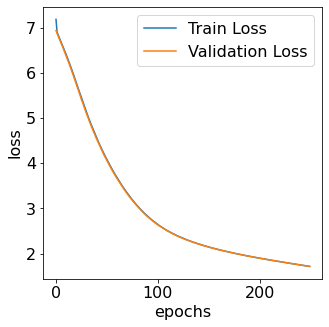

In [36]:
loss1 = pd.read_csv('../thesis/performance/imageTMVI/history.csv')

plt.figure(figsize=(5,5))
plt.rcParams.update(({'font.size': 16}))

plt.plot(loss1['train_loss'],label="Train Loss")
plt.plot(loss1['test_loss'], label="Validation Loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.savefig("../thesis/plots/uncertainty/LOSS_CIb_TMVI.pdf",bbox_inches='tight')
plt.show()
#plt.yscale('log')

#### Load weights

In [22]:
### recreate Model eta
nn_im.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
nn_im.load_weights("../thesis/models/CNNLastLayerTMVI")

### recreate whole Model
nn_imageTMVI.compile(optimizer=RMSprop(), loss=sample_bernoulli_nll, run_eagerly=False,metrics=[sample_bernoulli_nll])
#nn_im.fit(x =train_imgs_scaled,y = train_labels, verbose=True)
### load the state of the old model
nn_imageTMVI.load_weights("../thesis/models/CNNLastLayerTMVIWhole")

## Performance

In [34]:
y_pred = nn_imageTMVI.predict(test_imgs_scaled,batch_size =1)
samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(6626,1)

In [35]:
# logscore
logScore(test_labels,predictions)

-0.0764080076445391

In [36]:
# AUC
score, ci_lower, ci_upper, scores =score_ci(test_labels, meanpred, score_fun=roc_auc_score)
print("AUC={:.2f}, 95% CI: {:.2f}-{:.2f}".format(score, ci_lower, ci_upper))
ciAuc= "{:.2f}-{:.2f}".format(ci_lower, ci_upper)

AUC=0.83, 95% CI: 0.80-0.86


## Posterior for 1, 2 images

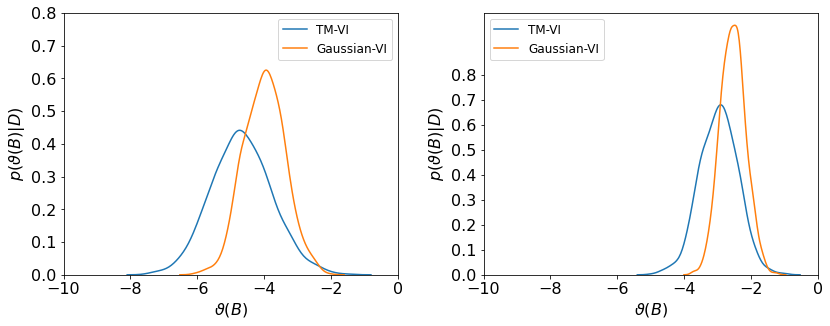

In [28]:
fig =plt.figure(figsize=(12,5))
plt.rcParams.update(({'font.size': 16}))
plt.subplot(121)
y_pred = nn_im.predict(test_imgs_scaled[8:9],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2,label="TM-VI")

y_pred = nn_imG.predict(test_imgs_scaled[8:9],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2, label="Gaussian-VI")
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(np.arange(-10, 2, 2))
plt.xlabel("$\\vartheta(B)$")
plt.ylabel("$p(\\vartheta(B)|D)$")

plt.legend(fontsize=12)
plt.subplot(122)
y_pred = nn_im.predict(test_imgs_scaled[7:8],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2,label="TM-VI")

y_pred = nn_imG.predict(test_imgs_scaled[7:8],batch_size =1)
flat_list = [item for sublist in y_pred for item in sublist]
flat_list2 =[item for sublist in flat_list for item in sublist]
sns.kdeplot(flat_list2, label="Gaussian-VI")
plt.xlabel("$\\vartheta(B)$")
plt.yticks(np.arange(0, 0.9, 0.1))
plt.xticks(np.arange(-10, 2, 2))
plt.ylabel("$p(\\vartheta(B)|D)$")
plt.legend(fontsize=12)
fig.tight_layout(pad=1.5)

#plt.savefig('./plots/uncertainty/imagePosteriorExamples.pdf')
# plt.show()

## OOD 
### Predictions before sigmoid

In [29]:
# theta random images
y_predTabOOD = nn_im.predict(oodRandom,batch_size =1)
samplesImgOOD = y_predTabOOD.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOOD = samplesImgOOD.mean(axis=1)  ###mean samples 
predictionsImgOOD=meanpredImgOOD.reshape(17,1)
# IQR quantiles
y_predictions_25ImgOOD=np.quantile(samplesImgOOD,0.25,axis=1)
y_predictions_75IMGOOD=np.quantile(samplesImgOOD,0.75,axis=1)


# data
ImgCenterOOD = [sublist[-1] for sublist in predictionsImgOOD]
ImgLowOOD = [sublist[-1] for sublist in y_predictions_25ImgOOD.reshape(17,1)]
ImgHighOOD = [sublist[-1] for sublist in y_predictions_75IMGOOD.reshape(17,1)]
# IQR range
ImgwidthOOD= [x1 - x2 for (x1, x2) in zip(ImgHighOOD, ImgLowOOD)]


# theta augmentation images
y_predTabOODA = nn_im.predict(bright,batch_size =1)
samplesImgOODA = y_predTabOODA.reshape(-1, 1000) ###every datapoint one sample
meanpredImgOODA = samplesImgOODA.mean(axis=1)  ###mean samples 
predictionsImgOODA=meanpredImgOODA.reshape(103,1)
# IQR quantiles
y_predictions_25ImgOODA=np.quantile(samplesImgOODA,0.25,axis=1)
y_predictions_75IMGOODA=np.quantile(samplesImgOODA,0.75,axis=1)
# data
ImgCenterOODA = [sublist[-1] for sublist in predictionsImgOODA]
ImgLowOODA = [sublist[-1] for sublist in y_predictions_25ImgOODA.reshape(103,1)]
ImgHighOODA = [sublist[-1] for sublist in y_predictions_75IMGOODA.reshape(103,1)]
# IQR range
ImgwidthOODA= [x1 - x2 for (x1, x2) in zip(ImgHighOODA, ImgLowOODA)]

In [30]:
#image in-distribution

y_pred = nn_im.predict(test_imgs_scaled[0:120],batch_size =1)
samples = y_pred.reshape(-1, 1000) ###every datapoint one sample
meanpred = samples.mean(axis=1)  ###mean samples 
predictions=meanpred.reshape(120,1)
# IQR quantiles
y_predictions_25=np.quantile(samples,0.25,axis=1)
y_predictions_75=np.quantile(samples,0.75,axis=1)
# data
ImgCenter = [sublist[-1] for sublist in meanpred.reshape(120,1)]
ImgLow = [sublist[-1] for sublist in y_predictions_25.reshape(120,1)]
ImgHigh = [sublist[-1] for sublist in y_predictions_75.reshape(120,1)]
#IQR range
Imgwidth= [x1 - x2 for (x1, x2) in zip(ImgHigh, ImgLow)]

imagedata = pd.DataFrame(
    {'width': Imgwidth,
     'center': ImgCenter
    })

# Out of distribution random

imagadataOOD = pd.DataFrame(
    {'width': ImgwidthOOD,
     'center': ImgCenterOOD
    })

# Out of distribution augmented images

imagadataOODA = pd.DataFrame(
    {'width': ImgwidthOODA,
     'center': ImgCenterOODA
    })

## Compare PPD of TM-VI with Gaussian-VI

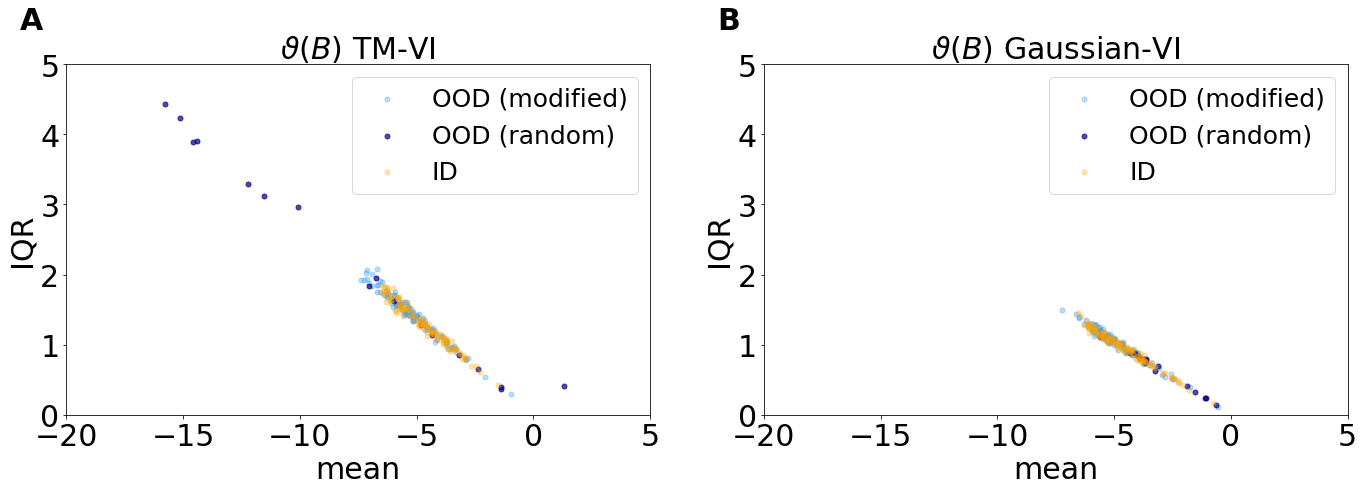

In [35]:
fig = plt.figure(figsize=(20,8))

plt.rcParams.update(({'font.size': 30}))
fig.add_subplot(121)
plt.scatter(imagadataOODA["center"],imagadataOODA["width"],alpha=0.3,s=25, label= "OOD (modified)",color="dodgerblue")
plt.scatter(imagadataOOD["center"],imagadataOOD["width"],alpha=0.7,s=25, label= "OOD (random)",color="darkblue")
plt.scatter(imagedata["center"],imagedata["width"],label="ID",alpha=0.3,s=25,color="orange")
plt.text(-22, 5.5,"A", 
            size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean")
plt.title("$\\vartheta(B)$ TM-VI",fontsize=30)
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=25)
fig.add_subplot(122)
plt.scatter(GimagadataOODA["Gcenter"],GimagadataOODA["Gwidth"],label="OOD (modified)",s=25,alpha=0.3, color="dodgerblue")
plt.scatter(GimagadataOOD["Gcenter"],GimagadataOOD["Gwidth"],label="OOD (random)",s=25,alpha=0.7,color="darkblue")
plt.scatter(Gimagedata["Gcenter"],Gimagedata["Gwidth"],label="ID",alpha=0.3,s=25,color="orange")
plt.text(-22, 5.5,"B", 
            size=30, weight='bold')
plt.ylabel("IQR")
plt.xlabel("mean")
plt.title("$\\vartheta(B)$ Gaussian-VI",fontsize=30)
plt.yticks(np.arange(0, 6, 1))
plt.xticks(np.arange(-20, 10, 5))
plt.legend(fontsize=25)
fig.tight_layout(pad=1.5)

#plt.savefig("../thesis/plots/uncertainty/imagegausTMVIcompare1.pdf")

In [44]:
%reload_ext version_information
%version_information tensorflow,numpy, pandas, matplotlib

Software versions
Python 3.9.7 64bit [GCC 7.5.0]
IPython 7.27.0
OS Linux 5.8.0 63 generic x86_64 with glibc2.32
tensorflow 2.4.1
numpy 1.21.2
pandas 1.3.3
matplotlib 3.4.3
Mon Nov 29 18:05:03 2021 CET